In [1]:
import numpy as np
import scipy.linalg as LA
import scipy.sparse as spr
import scipy.sparse.linalg as spr_LA
from time import time
import matplotlib.pyplot as plt
from sklearn import datasets

# ================================================================
# Load data
# ================================================================
filename = "/content/ijcnn1.bz2"
A, b = datasets.load_svmlight_file(filename)
A = A.tocsr()
m, n = A.shape
print("The dataset {}. The dimensions: m={}, n={}".format(filename[5:], m, n))
lam1 = 1.0    # lambda_1 for ||x||_1
lam2 = 150.0  # lambda_2 for ||D x||_1

K = (A.T.multiply(-b)).T.tocsr()

# find norm of K^T K (optional)
L = spr_LA.svds(K, k=1, return_singular_vectors=False)**2
print("approx lipschitz constant ||K||^2 =", float(L))

# ================================================================
# Difference operator D (first-order)
# ================================================================
D1 = np.eye(n-1, n)  # k=0 is the default for np.eye
D2 = np.eye(n-1, n, k=1)  # Use k=1 for the offset
D = D2 - D1
print(D)
# np.linalg.det(D)
norm_D = 2*np.cos(np.pi/(2*n))
# L = np.sqrt(np.max(LA.eigh(D.dot(D.T))[0]))
# print(L)
print("Norm_D:", norm_D)

# starting point
x0 = np.zeros(n)
y0 = 1e-9 * np.random.randn(n-1)

# ================================================================
# Functions
# ================================================================
f = lambda u: np.log(1. + np.exp(u)).sum()

def df(u):
    exp_u = np.exp(u)
    return exp_u/(1.+exp_u)

dh = lambda x, Kx: K.T.dot(df(Kx))

# energy: J(x) = f(Kx) + lam ||D x||_1
# J = lambda x, Kx: f(Kx) + lam * LA.norm(D.dot(x), 1)

J = lambda x, Kx: f(Kx) + lam1*LA.norm(x,1) + lam2*LA.norm(D.dot(x),1)


# prox of (lam||.||_1)^* is clip to infinity ball radius lam
# def prox_g_conj(v: np.ndarray, lam: float, sigma: float) -> np.ndarray:
#     return np.clip(v, -lam, lam)

def prox_f(x, tau):  # prox_{tau * lam1||.||1}
    t = tau * lam1
    return x + np.clip(-x, -t, t)   # soft-threshold

def prox_g_conj(v, sigma):          # prox_{sigma * (lam2||.||_1)^*}
    return np.clip(v, -lam2, lam2)  # projection to ||.||_inf <= lam2


The dataset ent/ijcnn1.bz2. The dimensions: m=49990, n=22
approx lipschitz constant ||K||^2 = 11524.229276763006
[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0. 

/tmp/ipython-input-596382199.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("approx lipschitz constant ||K||^2 =", float(L))


In [2]:
def pd_Golden(J, K, D, x0, y0,
                        sigma, tau, phi, numb_iter=100):

    begin = time()
    x, y, z = x0.copy(), y0.copy(), x0.copy()
    values = [J(x0, K.dot(x0))]
    tt = [0.0]
    tau_values, sigma_values = [], []

    for i in range(numb_iter):
        z = x - (1/phi) * (x - z)

        Kx = K.dot(x)
        grad_h = dh(x, Kx)

        # primal: prox_f( z - tau D^T y - tau grad_h )
        x_bar = z - tau * (D.T.dot(y)) - tau * grad_h
        x = prox_f(x_bar, tau)

        # dual: prox_{sigma g^*}( y + sigma D x )
        y = prox_g_conj(y + sigma * (D.dot(x)), sigma)

        values.append(J(x, K.dot(x)))
        tt.append(time() - begin)
        tau_values.append(tau)
        sigma_values.append(sigma)

        print(f"[GRPDA] Iter {i}: J={values[-1]}, tau={tau}, sigma={sigma}")

    return [values, x, y, tt, sigma_values, tau_values]


def pd_CV(J, K, D, x0, y0,
                    sigma, tau, numb_iter=100):

    begin = time()
    theta = 1.0
    x, y, z = x0.copy(), y0.copy(), x0.copy()
    values = [J(x0, K.dot(x0))]
    tt = [0.0]
    tau_values, sigma_values = [], []

    for i in range(numb_iter):
        Kx = K.dot(x)
        grad_h = dh(x, Kx)

        # primal
        x_bar = x - tau * (D.T.dot(y)) - tau * grad_h
        x1 = prox_f(x_bar, tau)

        # extrapolation
        z = x1 + theta * (x1 - x)

        # dual uses D z
        y = prox_g_conj(y + sigma * (D.dot(z)), sigma)

        x = x1
        values.append(J(x, K.dot(x)))
        tt.append(time() - begin)
        tau_values.append(tau)
        sigma_values.append(sigma)

        print(f"[CV] Iter {i}: J={values[-1]}, tau={tau}, sigma={sigma}, theta={theta}")

    return [values, x, y, tt, tau_values, sigma_values]


In [3]:
def pd_Golden_Partial_adaptive(J, K, D, x0, y0, mu, mu1, beta, phi, tau, numb_iter=100):
    begin = time()

    x, y, z = x0.copy(), y0.copy(), x0.copy()
    values = [J(x0, K.dot(x0))]
    tt = [0.0]
    tau_prev = tau
    tau_values = []
    sigma_values = []

    for i in range(numb_iter):
        # gradient of h at x
        Kx = K.dot(x)
        grad_h = dh(x, Kx)  # vector

        # extrapolation
        z = x - (1.0 / phi) * (x - z)

        # primal step (prox_f must be defined outside)
        x1 = prox_f(z - tau_prev * (D.T.dot(y)) - tau_prev * grad_h, tau_prev)

        x_norm = LA.norm(x - x1)

        Dx_norm = LA.norm(D.dot(x) - D.dot(x1))

        Kx1 = K.dot(x1)
        grad_h1 = dh(x1, Kx1)
        dhx_norm = LA.norm(grad_h - grad_h1)
        if x_norm == 0:
            tau_n = tau_prev
        else:
            if Dx_norm != 0 and dhx_norm != 0:
                tau_n = min(tau_prev,
                            (mu / np.sqrt(beta)) * (x_norm / Dx_norm),
                            mu1 * (x_norm / dhx_norm))  # mu should be > 2*mu1
            elif Dx_norm != 0 and dhx_norm == 0:
                tau_n = min(tau_prev,
                            (mu / np.sqrt(beta)) * (x_norm / Dx_norm))
            elif Dx_norm == 0 and dhx_norm != 0:
                tau_n = min(tau_prev,
                            mu1 * (x_norm / dhx_norm))
            else:
                tau_n = tau_prev
        # -----------------------------------------------

        sigma_n = beta * tau_n

        # dual update uses D x1
        y1 = prox_g_conj(y + sigma_n * D.dot(x1), sigma_n)

        # record objective at x1
        J_new = J(x1, Kx1)
        values.append(J_new)
        tau_values.append(tau_n)
        sigma_values.append(sigma_n)
        tt.append(time() - begin)

        print(f"Iteration {i}: J = {J_new}, tau_n = {tau_n}, x_norm = {x_norm}, Dx_norm = {Dx_norm}, dhx_norm = {dhx_norm}")

        # update iterates
        x, y, tau_prev = x1, y1, tau_n

        if values[-1] <= 1e-16:
            print("Iter:", i+1)
            print("----- Golden-Ratio PDA with partial adaptive step size -----")
            print("Time execution:", round(time() - begin, 2))
            break

    if values[-1] > 1e-16:
        print("Golden-Ratio PDA with partial adaptive step size does not terminate after",
              round(time() - begin, 2), "seconds")

    return [values, x, y, tt, sigma_values, tau_values]


In [4]:


def pd_adaptive_Golden(J,
                       K, D, norm_D,
                       x0, y0,
                       tau, theta, beta,
                       tau_max, rho_val, phi,
                       numb_iter=100):

    begin = time()

    x, y, z = x0.copy(), y0.copy(), x0.copy()
    values = [J(x0, K.dot(x0))]
    tt = [0.0]

    tau_prev = tau
    theta_prev = theta
    tau_values = []
    sigma_values = []
    err = values[-1]

    for i in range(numb_iter):

        # GR extrapolation
        z = x - (1.0 / phi) * (x - z)

        # ---- dh used like your previous code: dh(x, Kx) ----
        Kx = K.dot(x)
        grad_h = dh(x, Kx)  # vector

        # primal update (composite: prox_f with D^T y + grad_h)
        x1 = prox_f(z - tau_prev * (D.T.dot(y)) - tau_prev * grad_h, tau_prev)

        # needed quantities
        dx = x - x1
        x_norm = LA.norm(dx)**2

        Kx1 = K.dot(x1)
        grad_h1 = dh(x1, Kx1)
        dh_diff = grad_h - grad_h1
        dhx_norm = LA.norm(dh_diff)**2

        # adaptive tau_n
        if dhx_norm != 0:
            L_bar_prev = (dhx_norm / x_norm)
            L_current1 = (phi * theta_prev) / (9.0 * tau_prev)
            L_n = L_current1 / (L_bar_prev + phi * beta * (norm_D**2))
            tau_n = min(rho_val * tau_prev, L_n, tau_max)
        else:
            tau_n = min(rho_val * tau_prev, tau_max)

        sigma_n = beta * tau_n

        # dual update uses D x1 (since g(Dx))
        y1 = prox_g_conj(y + sigma_n * D.dot(x1), sigma_n)

        # update theta
        theta_n = phi * (tau_n / tau_prev)
        tau_prev = tau_n
        theta_prev = theta_n

        # record
        J_new = J(x1, Kx1)
        values.append(J_new)
        tau_values.append(tau_n)
        sigma_values.append(sigma_n)
        tt.append(time() - begin)

        print(f"Iteration {i}: J_gap = {J_new}, tau_n = {tau_n}, ||x-x1|| = {LA.norm(dx)}, dhx_norm = {dhx_norm}")

        # move
        x, y = x1, y1
        err = J_new

        if err <= 1e-16:
            print("Iter:", i+1)
            print("----- Adaptive Golden-Ratio PDA -----")
            print("Time execution:", round(time() - begin, 2))
            break

    if err > 1e-16:
        print("Adaptive Golden-Ratio PDA does not terminate after",
              round(time() - begin, 2), "seconds")

    return [values, x, y, tt, sigma_values, tau_values]


################################################################################################

In [5]:
def VI_adaptive_aGRAAL(J, K, D,
                                x0, y0,
                                tau, theta, rho_val, tau_max,
                                norm_D, phi, numb_iter=100, tol=1e-16):

    begin = time()

    x  = x0.copy()
    y  = y0.copy()
    x1 = x.copy()
    y1 = y.copy()

    z_x = x.copy()
    z_y = y.copy()

    Kx  = K.dot(x)
    Kx1 = K.dot(x1)

    values = [J(x, Kx)]
    tt = [0.0]

    tau_prev, theta_prev = tau, theta
    L_n = None

    for k in range(numb_iter):
        # z = (x,y)
        z0 = np.concatenate((x,  y))
        z1 = np.concatenate((x1, y1))

        # F(x,y) = ( D^T y + ∇h(x),  -D x )
        Fz0_x = D.T.dot(y)  + dh(x,  Kx)
        Fz0_y = -D.dot(x)
        Fz1_x = D.T.dot(y1) + dh(x1, Kx1)
        Fz1_y = -D.dot(x1)

        F0 = np.concatenate((Fz0_x, Fz0_y))
        F1 = np.concatenate((Fz1_x, Fz1_y))

        z_norm  = LA.norm(z0 - z1)
        Fz_norm = LA.norm(F0 - F1)

        if Fz_norm != 0:
            L_n   = (phi * theta_prev / (4.0 * tau_prev)) * (z_norm / Fz_norm)**2
            tau_n = min(rho_val * tau_prev, L_n, tau_max)
        else:
            tau_n = min(rho_val * tau_prev, tau_max)

        # GR extrapolation
        z_x = x1 - (1.0 / phi) * (x1 - z_x)
        z_y = y1 - (1.0 / phi) * (y1 - z_y)

        grad_h_x = dh(x, Kx)

        # x-update with prox_f
        x_bar = z_x - tau_n * (D.T.dot(y1) + grad_h_x)
        x2 = prox_f(x_bar, tau_n)

        # y-update with Dx1
        y2 = prox_g_conj(z_y + tau_n * (D.dot(x1)), tau_n)

        Kx2 = K.dot(x2)
        val = J(x2, Kx2)
        values.append(val)
        tt.append(time() - begin)

        print(f"[VI-aGRAAL] Iter {k}: J={val}, tau={tau_n}")

        theta_n = phi * (tau_n / tau_prev)
        tau_prev, theta_prev = tau_n, theta_n

        # shift
        x, y = x1, y1
        x1, y1 = x2, y2
        Kx, Kx1 = Kx1, Kx2

        if val <= tol:
            break

    return [values, x1, y1, tt]


In [6]:
# ================================================================
# RUN for the dataset ijcnn1
# ================================================================
N = 10000

tau = 3.0e-4
theta = 1.0
beta = 2.7e6
tau_max = 1e7
phi = 1.50
rho_val = 1/phi + (1/phi**2)

tau_agraal = 3e-3
mu = 0.79
mu1 = .26
phi2 = 1.70
phi3 = 1.7
beta_par = 7e8
beta_adapt = 2e5

sigma_pd = 1.00e+04
tau_pd = 3e-06
tau_egrpda =  3.55e-06#3.55e-06, sigma=1.00e+03
sigma_egrpda = 1.00e+03
phi_egrpda = (1+ np.sqrt(5))/2

ans_adapt = pd_adaptive_Golden(J, K, D, norm_D,
                       x0, y0,
                       tau, theta, beta_adapt,
                       tau_max, rho_val, phi,
                       numb_iter=N)

ans_vi = VI_adaptive_aGRAAL(J, K, D, x0, y0,
                                     tau, theta, rho_val, tau_max,
                                     norm_D, phi, numb_iter=N)

ans_par = pd_Golden_Partial_adaptive(J, K, D, x0, y0, mu, mu1, beta, phi3, tau, numb_iter=N)
ans_golden = pd_Golden(J, K, D, x0, y0, sigma_egrpda, tau_egrpda, phi_egrpda, numb_iter=N)
ans_pd = pd_CV(J, K, D, x0, y0, sigma_pd, tau_pd, numb_iter=N)

Streaming output truncated to the last 5000 lines.
[CV] Iter 5000: J=13724.11511047051, tau=3e-06, sigma=10000.0, theta=1.0
[CV] Iter 5001: J=13723.997516513444, tau=3e-06, sigma=10000.0, theta=1.0
[CV] Iter 5002: J=13723.869368216441, tau=3e-06, sigma=10000.0, theta=1.0
[CV] Iter 5003: J=13723.73032808158, tau=3e-06, sigma=10000.0, theta=1.0
[CV] Iter 5004: J=13723.58064919885, tau=3e-06, sigma=10000.0, theta=1.0
[CV] Iter 5005: J=13723.421087005487, tau=3e-06, sigma=10000.0, theta=1.0
[CV] Iter 5006: J=13723.252790647222, tau=3e-06, sigma=10000.0, theta=1.0
[CV] Iter 5007: J=13723.077190200589, tau=3e-06, sigma=10000.0, theta=1.0
[CV] Iter 5008: J=13722.895842858248, tau=3e-06, sigma=10000.0, theta=1.0
[CV] Iter 5009: J=13722.710408660414, tau=3e-06, sigma=10000.0, theta=1.0
[CV] Iter 5010: J=13722.52230229716, tau=3e-06, sigma=10000.0, theta=1.0
[CV] Iter 5011: J=13722.33289627837, tau=3e-06, sigma=10000.0, theta=1.0
[CV] Iter 5012: J=13722.143299417154, tau=3e-06, sigma=10000.0, th

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

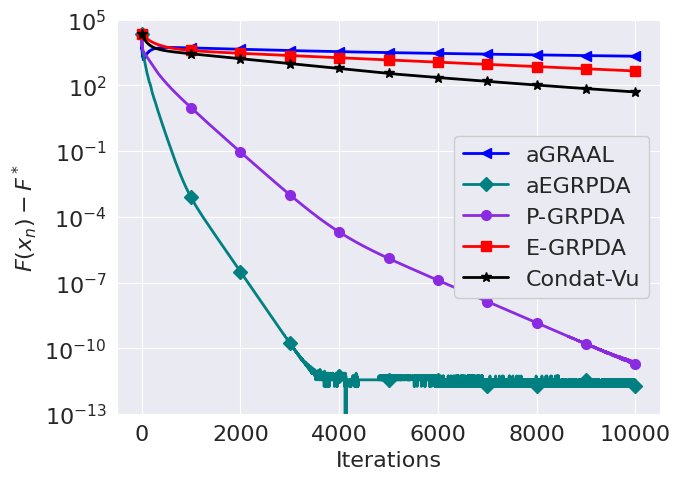

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# ===============================
# 1) Seaborn
# ===============================
sns.set_style('darkgrid')
plt.rcParams['legend.facecolor'] = plt.rcParams['axes.facecolor']

plt.rcParams.update({
    'font.size':        13,
    'figure.figsize':   (7, 5),
    'legend.fontsize':  16,
    'lines.linewidth':  2,
    'axes.labelsize':   16,
    'axes.titlesize':   10,
    'xtick.labelsize':  16,
    'ytick.labelsize':  16,
    'xtick.major.pad':  4,
    'ytick.major.pad':  4,
})

# ===============================
# 2) Prepare your gap data
# ===============================
F_vi = np.array(ans_vi[0], dtype=float)
F_ad = np.array(ans_adapt[0], dtype=float)
F_par = np.array(ans_par[0], dtype=float)
F_golden = np.array(ans_golden[0], dtype=float)
F_pd = np.array(ans_pd[0], dtype=float)

F_best = min(F_vi.min(), F_ad.min(), F_par.min(), F_golden.min(), F_pd.min())
gap_vi = np.maximum(F_vi - F_best, 1e-30)
gap_ad = np.maximum(F_ad - F_best, 1e-30)
gap_par = np.maximum(F_par - F_best, 1e-30)
gap_golden = np.maximum(F_golden - F_best, 1e-30)
gap_pd = np.maximum(F_pd - F_best, 1e-30)

data   = [gap_vi, gap_ad, gap_par, gap_golden, gap_pd]
labels = ['aGRAAL', 'aEGRPDA', 'P-GRPDA', 'E-GRPDA', 'Condat-Vu']
colors = ['blue', '#008080', '#8A2BE2', 'red', 'black']
markers = ['<', 'D', 'o', 's', '*']
msize = 7

# Use max length for x-axis; each curve uses its own length
iters_list = [np.arange(len(gap_vi)), np.arange(len(gap_ad)), np.arange(len(gap_par)), np.arange(len(gap_golden)), np.arange(len(gap_pd)) ]
markevery_list = [max(1, len(it)//10) for it in iters_list]

# ===============================
# 3) Plot
# ===============================
plt.figure()
for y, it, lbl, c, m, me in zip(data, iters_list, labels, colors, markers, markevery_list):
    plt.plot(it, y, color=c, marker=m, markersize=msize, markevery=me, label=lbl)

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r'$F(x_n)-F^*$')
plt.ylim([1e-13, 1e5])

plt.legend(framealpha=1.0)
plt.grid(True)
plt.tight_layout()

plt.savefig('logistic_regression_ijcnn1_compariosn_new.eps', dpi=700)
files.download('logistic_regression_ijcnn1_compariosn_new.eps')
plt.show()

/tmp/ipython-input-1691608235.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


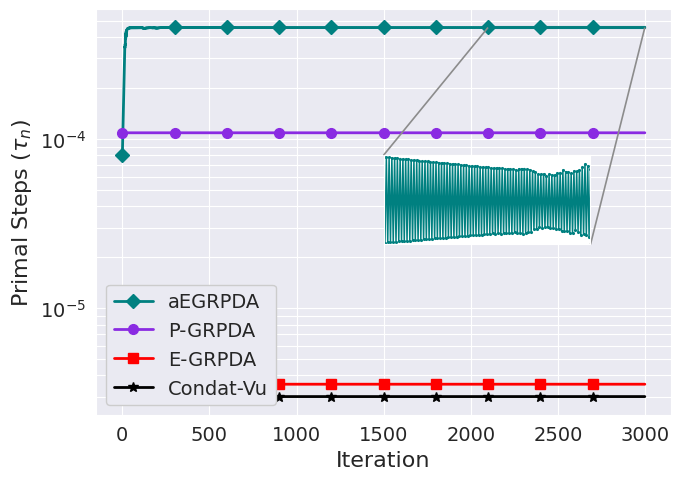

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-1691608235.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


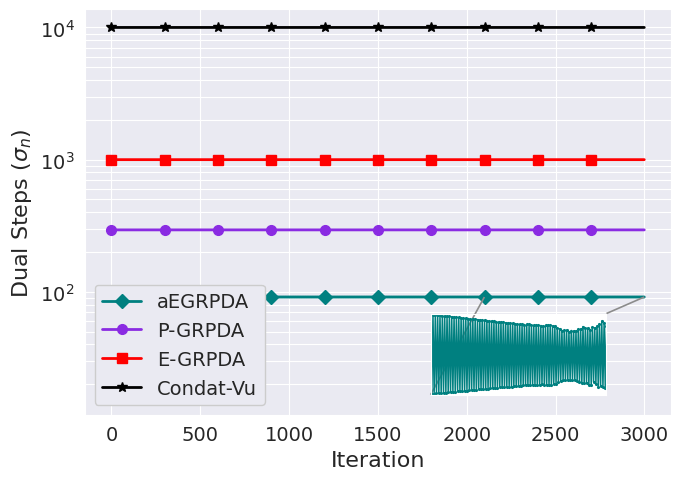

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle
from google.colab import files

# =========================
# settings
# =========================
MAXPLOT = 3000

def as_1d(v):
    v = np.asarray(v, dtype=float).squeeze()
    if v.ndim == 0:
        v = v.reshape(1)
    if v.ndim != 1:
        v = v[:, 0] if v.shape[0] >= v.shape[-1] else v[0, :]
        v = np.asarray(v, dtype=float).ravel()
    return v

def trim(v, maxlen=MAXPLOT):
    v = as_1d(v)
    return v[:min(len(v), maxlen)]

def add_zoom_with_connectors(ax, series, *,
                            color="#EE82EE",
                            connector_color="0.55",
                            last_k=900,
                            stride=6,
                            qlo=0.02, qhi=0.98,
                            pad_frac=0.03,
                            anchor=(0.18, 0.72),
                            width="36%", height="22%",
                            inset_loc="lower left",
                            loc1=2, loc2=4):

    series = as_1d(series)
    n = len(series)
    if n < 2:
        return None

    i2 = n - 1
    i1 = max(0, i2 - last_k)

    x = np.arange(n)
    xs = x[i1:i2+1:stride]
    ys = series[i1:i2+1:stride]
    if len(ys) == 0:
        return None

    ylo = float(np.quantile(ys, qlo))
    yhi = float(np.quantile(ys, qhi))
    pad = pad_frac * (yhi - ylo + 1e-30)

    axins = inset_axes(
        ax, width=width, height=height, loc=inset_loc,
        bbox_to_anchor=(anchor[0], anchor[1], 1, 1),
        bbox_transform=ax.transAxes, borderpad=0.0
    )

    axins.plot(xs, ys, color=color, linewidth=1.1)
    axins.plot(xs, ys, linestyle="None", marker=".", markersize=2.5, color=color)
    axins.set_xlim(i1, i2)
    axins.set_ylim(ylo - pad, yhi + pad)
    axins.set_yscale("linear")

    axins.set_xticks([]); axins.set_yticks([])
    axins.tick_params(which="both", left=False, right=False, bottom=False, top=False,
                      labelleft=False, labelright=False, labelbottom=False, labeltop=False)
    axins.grid(True, which="both")
    axins.set_facecolor("white")

    rect = Rectangle((i1, ylo - pad), (i2 - i1), (yhi - ylo + 2*pad),
                     fill=False, edgecolor=color, linewidth=1.5)
    ax.add_patch(rect)

    mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc="none", ec=connector_color, lw=1.2)
    return axins

# =========================
# Extract + TRIM to 3000
# =========================
tau_ae   = trim(ans_adapt[5])   # aEGRPDA
sigma_ae = trim(ans_adapt[4])

tau_pg   = trim(ans_par[5])     # P-GRPDA
sigma_pg = trim(ans_par[4])

tau_eg   = trim(ans_golden[5])  # E-GRPDA
sigma_eg = trim(ans_golden[4])

tau_cv   = trim(ans_pd[4])      # Condat–Vu
sigma_cv = trim(ans_pd[5])

# =========================
# Styling (matplotlib only)
# =========================
plt.rcParams.update({
    "font.size": 13,
    "figure.figsize": (7, 5),
    "legend.fontsize": 14,
    "lines.linewidth": 2,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
})

# =========================
# 1) PRIMAL steps (tau_n) — first 3000
# =========================
fig, ax = plt.subplots()

series_tau = [
    (tau_ae, 'aEGRPDA',   '#008080', 'D'),
    (tau_pg, 'P-GRPDA',   '#8A2BE2',     'o'),
    (tau_eg, 'E-GRPDA',   'red', 's'),
    (tau_cv, 'Condat-Vu', 'black',    '*'),
]

for s, label, color, marker in series_tau:
    it = np.arange(len(s))
    me = max(1, len(it)//10)
    ax.plot(it, s, label=label, color=color, marker=marker, markersize=7, markevery=me)

ax.set_yscale("log")
ax.set_xlabel("Iteration")
ax.set_ylabel(r"Primal Steps ($\tau_n$)")
ax.grid(True, which="both")
ax.legend(framealpha=1.0, loc="lower left")

# inset on trimmed aEGRPDA tau
add_zoom_with_connectors(
    ax, tau_ae,
    color="#008080",
    connector_color="0.55",
    last_k=min(900, len(tau_ae)-1),
    stride=6,
    qlo=0.02, qhi=0.98, pad_frac=0.03,
    anchor=(0.5, 0.42), width="36%", height="22%",
    inset_loc="lower left",
    loc1=2, loc2=4
)

plt.tight_layout()
primal_eps = "logistic_regression_ijcnn1_primal_steps_first3000.eps"
primal_pdf = "logistic_regression_ijcnn1_primal_steps_first3000.pdf"
plt.savefig(primal_eps, dpi=600, bbox_inches="tight")
plt.savefig(primal_pdf, bbox_inches="tight")
plt.show()
files.download(primal_eps)

# =========================
# 2) DUAL steps (sigma_n) — first 3000
# =========================
fig, ax = plt.subplots()


series_sigma = [
    (sigma_ae, 'aEGRPDA',   '#008080', 'D'),
    (sigma_pg, 'P-GRPDA',   '#8A2BE2',     'o'),
    (sigma_eg, 'E-GRPDA',   'red', 's'),
    (sigma_cv, 'Condat-Vu', 'black',    '*'),
]

for s, label, color, marker in series_sigma:
    it = np.arange(len(s))
    me = max(1, len(it)//10)
    ax.plot(it, s, label=label, color=color, marker=marker, markersize=7, markevery=me)

ax.set_yscale("log")
ax.set_xlabel("Iteration")
ax.set_ylabel(r"Dual Steps ($\sigma_n$)")
ax.grid(True, which="both")
ax.legend(framealpha=1.0, loc="lower left")

# inset on trimmed aEGRPDA sigma
add_zoom_with_connectors(
    ax, sigma_ae,
    color="#008080",
    connector_color="0.55",
    last_k=min(900, len(sigma_ae)-1),
    stride=6,
    qlo=0.02, qhi=0.98, pad_frac=0.02,
    anchor=(0.59, 0.05), width="30%", height="20%",
    inset_loc="lower left",
    loc1=1, loc2=3
)

plt.tight_layout()
dual_eps = "logistic_regression_ijcnn1_dual_steps_first3000.eps"
dual_pdf = "logistic_regression_ijcnn1_dual_steps_first3000.pdf"
plt.savefig(dual_eps, dpi=600, bbox_inches="tight")
plt.savefig(dual_pdf, bbox_inches="tight")
plt.show()
files.download(dual_eps)
